In [1]:
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve,average_precision_score
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
def cross_validate(x, y,folds=10, model=None):

    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    cv_results={}
    cv_results['estimators']=[]
    cv_results['test_acc']=[]
    cv_results['precision']=[]
    cv_results['recall']=[]
    cv_results['average_precision']=[]
    print('cross validating...')
    
    for train_idx, test_idx in kfold.split(x, y):

        x_train = x[train_idx]
        y_train = y[train_idx]
        x_test = x[test_idx]
        y_test = y[test_idx]


        model.fit(x_train, y_train.flatten())
        y_proba = model.predict_proba(x_test)[:,1]
        acc = model.score(x_test, y_test)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        mean_precision = average_precision_score(y_test, y_proba)
        
        cv_results['estimators'] += [model]
        cv_results['test_acc'] += [acc]
        cv_results['precision'] += [precision]
        cv_results['recall'] += [recall]
        cv_results['average_precision'] += [mean_precision]

    
    return cv_results

def get_best_model(cv_results):
    '''
    Function takes in results from function cross_validate and finds the nest estimator
    If multiple estimators have achieved the same precision, then a random one is selected
    '''
    best_score=None
    best_estimator=None
    for i,e in enumerate(cv_results['estimators']):
        score = cv_results['precision']
        
        if best_score is None or score>best_score:
            best_score = score
            best_estimator = e
    return best_score, best_estimator
    
    

## Cross validating with unbalanced data
   * after get_best_model is run, the best balanced model will be saved

In [4]:

    
data = "../data_test/MergedData_Unbalancedv2.tsv"
labels = "../data_test/MergedLabels_Unbalancedv2.tsv"
save_best = True
model_fn = "../models/RiboVsPoly_unbalancedv2.sav"

#classifier_genes = np.loadtxt('../data_test/ClassifierGenes_v2.txt', dtype='str')

if '.tsv' in data:
    X = pd.read_csv(data, sep='\t', index_col=0)
    Y = pd.read_csv(labels, sep='\t', index_col=0)
else:
    raise ValueError('File does not appear to be tab delimited due to erronious extension. Make sure the file is tab delimited')

#X = X.T.loc[classifier_genes].T #making sure genes match dimensionality of trained classifier
#X = X.fillna(0)


model = RandomForestClassifier(n_estimators=1000, max_depth=5,random_state=42, oob_score=True, n_jobs=-1, verbose=0)
unbalanced_cv_results = cross_validate(X.values, Y.values, model=model)

cv_mean_precision = np.mean(unbalanced_cv_results['average_precision'])
print('10-Fold CV average precision: %.3f'%cv_mean_precision)

if save_best:
    best_score, best_estimator = get_best_model(unbalanced_cv_results)
    pickle.dump(best_estimator, open(model_fn, 'wb'))

#np.save('./results/RF_10-foldCV.npy',cv_results)



cross validating...
10-Fold CV average precision: 0.996


## Cross validating with balanced data
   * after get_best_model is run, the best unbalanced model will be saved

In [5]:

    
data = "../data_test/MergedData_Balancedv2.tsv"
labels = "../data_test/MergedLabels_Balancedv2.tsv"
save_best = True
model_fn = "../models/RiboVsPoly_balancedv2.sav"

#classifier_genes = np.loadtxt('../data_test/ClassifierGenes_v2.txt', dtype='str')

if '.tsv' in data:
    X = pd.read_csv(data, sep='\t', index_col=0)
    Y = pd.read_csv(labels, sep='\t', index_col=0)
else:
    raise ValueError('File does not appear to be tab delimited due to erronious extension. Make sure the file is tab delimited')

#X = X.T.loc[classifier_genes].T #making sure genes match dimensionality of trained classifier
#X = X.fillna(0)


model = RandomForestClassifier(n_estimators=1000, max_depth=5,random_state=42, oob_score=True, n_jobs=-1, verbose=0)
balanced_cv_results = cross_validate(X.values, Y.values, model=model)

cv_mean_precision = np.mean(balanced_cv_results['average_precision'])
print('10-Fold CV average precision: %.3f'%cv_mean_precision)

if save_best:
    best_score, best_estimator = get_best_model(balanced_cv_results)
    pickle.dump(best_estimator, open(model_fn, 'wb'))

#np.save('./results/RF_10-foldCV.npy',cv_results)



cross validating...
10-Fold CV average precision: 0.995


In [6]:
balanced_acc = balanced_cv_results['test_acc']
unbalanced_acc = unbalanced_cv_results['test_acc']

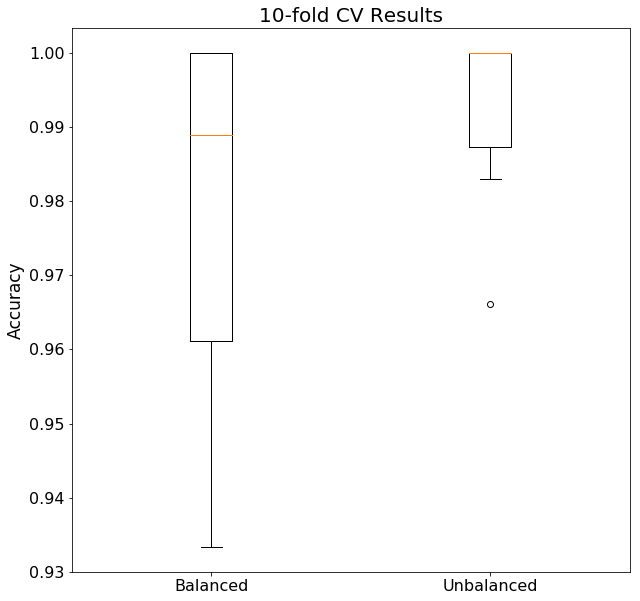

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.boxplot([balanced_acc, unbalanced_acc])
plt.ylabel("Accuracy", fontsize=17)
plt.yticks(fontsize=16)
plt.xticks([1,2], ["Balanced", "Unbalanced"], fontsize=16)
plt.title("10-fold CV Results", fontsize=20)
plt.show()
plt.close()